In [2]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

# Support Vector Machine (SVM) Model


In [3]:
# Uncomment to get the correct versions
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output() 


In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score



In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Get the data

x_train_path = '../../data/train_test_split/x_train_cluster.csv'
y_train_path = '../../data/train_test_split/y_train.csv'

x_test_path = '../../data/train_test_split/x_test_cluster.csv'
y_test_path = '../../data/train_test_split/y_test.csv'

x_train_df = pd.read_csv(x_train_path) 
y_train_df = pd.read_csv(y_train_path) 

x_test_df = pd.read_csv(x_test_path)
y_test_df = pd.read_csv(y_test_path)



In [7]:
x_train_df['dataset_type'] = 'train'
x_test_df['dataset_type'] = 'test'

# Combine train and test
train_df = pd.merge(x_train_df, y_train_df, how='left', left_index=True, right_index=True)
test_df = pd.merge(x_test_df, y_test_df,how='left', left_index=True, right_index=True)


In [8]:
# Convert all the clusters into objects
train_df['KMeans_Cluster'] = train_df['KMeans_Cluster'].astype(object)
test_df['KMeans_Cluster'] = test_df['KMeans_Cluster'].astype(object)

train_df['SVD_KMeans_Cluster'] = train_df['SVD_KMeans_Cluster'].astype(object)
test_df['SVD_KMeans_Cluster'] = test_df['SVD_KMeans_Cluster'].astype(object)

train_df['DBSCAN_Cluster_PCA'] = train_df['DBSCAN_Cluster_PCA'].astype(object)
test_df['DBSCAN_Cluster_PCA'] = test_df['DBSCAN_Cluster_PCA'].astype(object)

In [9]:

combined_df = pd.concat([train_df, test_df], axis=0)
combined_df.reset_index(drop=True, inplace=True)


In [10]:
combined_df.head() 

,Unnamed: 0.1,name,rating,ranking,year,position,height,weight,latitude,longitude,hometown_city,state_province,hometown_country,stars,committed_to,athlete_id,conference,latitude_school,longitude_school,wins_rolling_2year,games_played_rolling_2year,post_season_wins_rolling_2year,point_diff_rolling_2year,win_pct_rolling_2year,distance_miles,side_of_ball,position_group,DBSCAN_Cluster_PCA,SVD_KMeans_Cluster,KMeans_Cluster,dataset_type,Unnamed: 0,is_drafted
0,361,C.J. Prosise,0.8915,365.0,2012,S,74.0,190.0,35.166812,-80.751458,Woodberry Forest,VA,USA,4,Notre Dame,535958.0,FBS Independents,41.698378,-86.233942,16.0,26.0,1.0,190.0,0.615385,539.828641,defense,d_backfield,0,1,2,train,361,1.0
1,14685,Jaylon Haynes,0.8166,1684.0,2017,DT,73.0,290.0,29.312480,-96.098238,Wharton,TX,USA,3,UTSA,4245215.0,American Athletic,29.416983,-98.478814,9.0,25.0,0.0,-118.0,0.360000,143.529399,defense,d_line,0,3,1,train,14685,0.0
2,15617,Nasser Clark,0.7667,3299.0,2017,RB,70.0,190.0,34.597245,-83.763306,Cleveland,GA,USA,2,Army,NaN,American Athletic,41.387492,-73.964089,10.0,25.0,1.0,62.0,0.400000,709.669019,offense,running_back,1,3,0,train,15617,0.0
3,3870,Courtney Miggins,0.8111,1568.0,2013,SDE,77.0,240.0,33.712331,-84.105194,Lithonia,GA,USA,3,Louisiana,NaN,Sun Belt,30.215843,-92.041737,18.0,26.0,2.0,128.0,0.692308,523.980272,defense,d_line,0,1,1,train,3870,0.0
4,20038,Zaylin Wood,0.8383,1429.0,2019,SDE,74.0,262.0,33.537889,-85.253282,Bowdon,GA,USA,3,Middle Tennessee,4428925.0,Conference USA,35.851146,-86.368165,15.0,27.0,1.0,29.0,0.555556,171.919819,defense,d_line,0,1,1,train,20038,0.0


In [11]:
train_df.head() 

,Unnamed: 0.1,name,rating,ranking,year,position,height,weight,latitude,longitude,hometown_city,state_province,hometown_country,stars,committed_to,athlete_id,conference,latitude_school,longitude_school,wins_rolling_2year,games_played_rolling_2year,post_season_wins_rolling_2year,point_diff_rolling_2year,win_pct_rolling_2year,distance_miles,side_of_ball,position_group,DBSCAN_Cluster_PCA,SVD_KMeans_Cluster,KMeans_Cluster,dataset_type,Unnamed: 0,is_drafted
0,361,C.J. Prosise,0.8915,365.0,2012,S,74.0,190.0,35.166812,-80.751458,Woodberry Forest,VA,USA,4,Notre Dame,535958.0,FBS Independents,41.698378,-86.233942,16.0,26.0,1.0,190.0,0.615385,539.828641,defense,d_backfield,0,1,2,train,361,1.0
1,14685,Jaylon Haynes,0.8166,1684.0,2017,DT,73.0,290.0,29.312480,-96.098238,Wharton,TX,USA,3,UTSA,4245215.0,American Athletic,29.416983,-98.478814,9.0,25.0,0.0,-118.0,0.360000,143.529399,defense,d_line,0,3,1,train,14685,0.0
2,15617,Nasser Clark,0.7667,3299.0,2017,RB,70.0,190.0,34.597245,-83.763306,Cleveland,GA,USA,2,Army,NaN,American Athletic,41.387492,-73.964089,10.0,25.0,1.0,62.0,0.400000,709.669019,offense,running_back,1,3,0,train,15617,0.0
3,3870,Courtney Miggins,0.8111,1568.0,2013,SDE,77.0,240.0,33.712331,-84.105194,Lithonia,GA,USA,3,Louisiana,NaN,Sun Belt,30.215843,-92.041737,18.0,26.0,2.0,128.0,0.692308,523.980272,defense,d_line,0,1,1,train,3870,0.0
4,20038,Zaylin Wood,0.8383,1429.0,2019,SDE,74.0,262.0,33.537889,-85.253282,Bowdon,GA,USA,3,Middle Tennessee,4428925.0,Conference USA,35.851146,-86.368165,15.0,27.0,1.0,29.0,0.555556,171.919819,defense,d_line,0,1,1,train,20038,0.0


In [12]:
# Display the Target rates of the training and testing datast 
print('Training Conversion Rate: ', round(train_df['is_drafted'].mean(),4)* 100.0, '%')
print('Testing Conversion Rate: ', round(test_df['is_drafted'].mean(),4) * 100.0, '%')



Training Conversion Rate:  8.62 %
Testing Conversion Rate:  8.24 %


In [13]:
numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars', 'games_played_rolling_2year','win_pct_rolling_2year']

# numerical_features = ['games_played_rolling_2year']
clusters = ['KMeans_Cluster', 'SVD_KMeans_Cluster', 'DBSCAN_Cluster_PCA']
categorical_features = ['position_group',  'state_province', 'side_of_ball']


features = numerical_features+clusters+categorical_features
target = ['is_drafted']


In [14]:
features 

['rating',
 'ranking',
 'height',
 'weight',
 'distance_miles',
 'stars',
 'games_played_rolling_2year',
 'win_pct_rolling_2year',
 'KMeans_Cluster',
 'SVD_KMeans_Cluster',
 'DBSCAN_Cluster_PCA',
 'position_group',
 'state_province',
 'side_of_ball']

## Pre-process the data

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features+clusters)
    ])

## Prepare the data

In [16]:
# Separate features and target in the balanced dataset
X = train_df[features]
y = train_df[target]


In [17]:
# Pre-process the train and test datasets
X_train = preprocessor.fit_transform(X)

X_test = test_df[features]
X_test_processed = preprocessor.transform(X_test)


In [18]:
# Get the target variables
y_train = y.to_numpy().ravel()
y_test = test_df[['is_drafted']].to_numpy().ravel()

### Hyperparameter Tuning

In [19]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score

# Define hyperparameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'gamma': [0.001, 0.01,'scale', 'auto'],  # Kernel coefficient for non-linear kernels
    'degree': [2, 3, 4]  # Degree for 'poly' kernel
}

# {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

# Initialize SVC with class weight balancing
svm_model = SVC(class_weight='balanced', random_state=42)
scoring = make_scorer(f1_score, average='micro')

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                           scoring=scoring, cv=5, n_jobs=-1)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

clear_output() 

print("Best hyperparameters:", best_params)
print(f"Best cross-validated F1 score: {best_score:.4f}")

# Optional: Extract all the results
cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)

# Display the results
results_df = results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
print("All cross-validation results:")
print(results_df)



Best hyperparameters: {'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validated F1 score: 0.9154
All cross-validation results:
                                                params  mean_test_score  \
93   {'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kern...         0.915446   
133  {'C': 1, 'degree': 4, 'gamma': 0.01, 'kernel':...         0.912939   
141  {'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel...         0.910210   
69   {'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel...         0.909151   
77   {'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kern...         0.907313   
85   {'C': 0.1, 'degree': 4, 'gamma': 0.01, 'kernel...         0.884589   
13   {'C': 0.01, 'degree': 2, 'gamma': 'auto', 'ker...         0.881472   
53   {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel...         0.860023   
117  {'C': 1, 'degree': 3, 'gamma': 0.01, 'kernel':...         0.859299   
41   {'C': 0.01, 'degree': 4, 'gamma': 'scale', 'ke...         0.856737   
61   {'C': 0.1, 'degree': 

In [20]:
results_df.head()

,params,mean_test_score,rank_test_score
93,"{'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kern...",0.915446,1
133,"{'C': 1, 'degree': 4, 'gamma': 0.01, 'kernel':...",0.912939,2
141,"{'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel...",0.910210,3
69,"{'C': 0.1, 'degree': 3, 'gamma': 0.01, 'kernel...",0.909151,4
77,"{'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kern...",0.907313,5


In [21]:
print(best_params)

{'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}


## Best Model


In [22]:
# Initialize the SVM model with the kernel of your choice (linear, poly, rbf etc.)
svm_model = SVC(**best_params, class_weight='balanced', random_state=42)

In [23]:
# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_processed)

In [24]:
# ## Create a Model Pipeline
# from sklearn.pipeline import Pipeline

# model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                  ('model', svm_model)])


In [25]:
# preprocessor = model_pipeline['preprocessor']
# svm_model = model_pipeline['model']


## Model Performance 

Calculate/Visualize the following: 
- F1- Score (Cross val mean and std)
- Confusion Matrix 
- Feature Importance

In [26]:
import evaluate_model as em 

In [27]:
f1_score = em.calculate_f1_score(y_test , y_pred)
print('F1 Score:', f1_score)

F1 Score: 0.9184628237259816


In [28]:
# Show the model results 
model_scores, model_scores_mean, model_scores_std = em.evaluate_cross_val_score(svm_model, X_test_processed, y_test)

clear_output()
print('Mean F1 Score: ', model_scores_mean)
print('Std F1 Score', model_scores_std )

Mean F1 Score:  0.08270676691729323
Std F1 Score 0.0005283671946814335


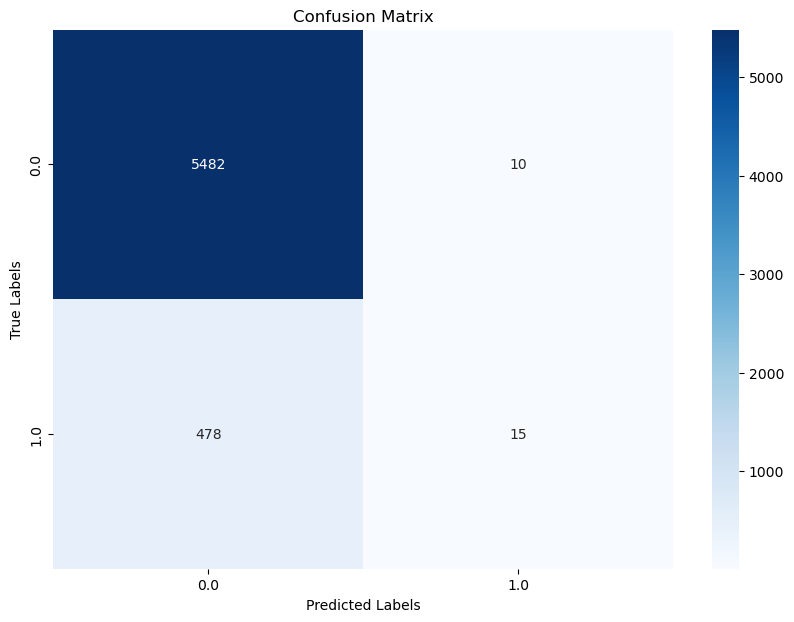

In [29]:
# Create a confusion matrix 
conf_mat = em.create_confusion_matrix(y_test, y_pred)

In [31]:
# em.svm_feature_importance(svm_model, preprocessor,X, y, visualize=True)